In [ ]:
!pip install --quiet scanpy

In [175]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Loading dataframes

In [3]:
#ROIS annotations
rois_df = pd.read_csv("sample_anotations.txt",sep='\t')
rois_df = rois_df.loc[:,'SlideName':'NormalizationFactor']

#Raw gene count
gene_raw_count_df = pd.read_csv("Kidney_Raw_TargetCountMatrix.txt",sep='\t')
#Gene count per AOI
gene_norm_count_df = pd.read_csv("Kidney_Q3Norm_TargetCountMatrix.txt",sep='\t')

Merging and Adapting to AnnData format

In [87]:
from anndata import AnnData

formated_data = gene_raw_count_df.set_index("TargetName").T
first_gene_id = formated_data.columns[0]
last_roi_var = rois_df.columns[-1]
formated_data = pd.merge(rois_df,formated_data,left_on='SegmentDisplayName',right_index=True)

#Matrix of observation*variables--ROI*gene
X = formated_data.loc[:,first_gene_id:].to_numpy()

#DataFrame indexed by genes id
var = list(formated_data.head(1).loc[:,first_gene_id:].columns)
var = pd.DataFrame(index=var)

#DataFrame indexed by observations(ROI) identifiers
obs = formated_data.loc[:,:last_roi_var].set_index("SegmentDisplayName")
adata = AnnData(X,var=var,obs=obs)

Following example graph from tutorial https://scanpy.readthedocs.io/en/stable/tutorials.html

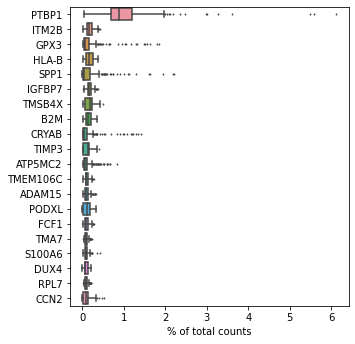

In [90]:
import scanpy as sc
sc.pl.highest_expr_genes(adata, n_top=20, )

Trying to replicate Ana's volcano plot

In [103]:
#Normalizing inside each roi
sc.pp.normalize_total(adata, target_sum=1e4)
#Natural log
sc.pp.log1p(adata)

In [107]:
#Hypothesis testing, samples: rois, control:normal,treat:dkd
sc.tl.rank_genes_groups(adata,groupby="disease_status",method='wilcoxon')

In [213]:
#Formats conversion
ranked_genes = pd.DataFrame()
for var in ['pvals_adj','logfoldchanges','names']:
    ranked_genes[var] = adata.uns['rank_genes_groups'][var].DKD

ranked_genes["-log_padj"] = -np.log10(ranked_genes.pvals_adj)

#Under-sampling low scored genes
ranked_genes["hue"] = ranked_genes["-log_padj"]*ranked_genes["logfoldchanges"]
ranked_genes["weights"] = ranked_genes.hue**2
ranked_genes = ranked_genes.sample(n=500,weights='weights')
selected_genes = ranked_genes[ranked_genes.weights>ranked_genes["weights"].quantile(0.97)]


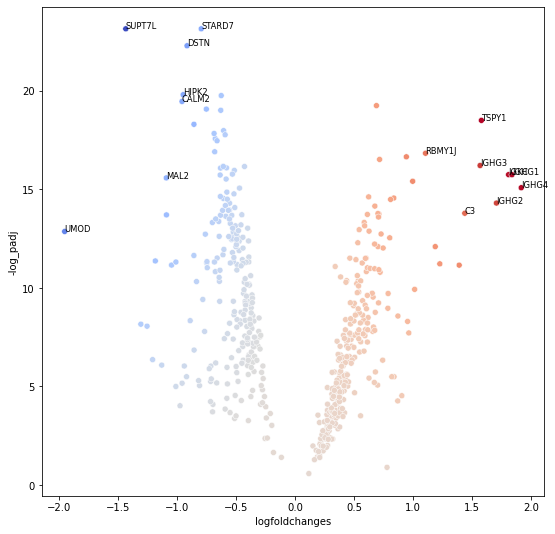

In [214]:
plt.figure(figsize=(9,9))
sns.scatterplot(data=ranked_genes,x='logfoldchanges',y="-log_padj",hue='hue',
                palette='coolwarm',legend=False)

#Annotating graph
for i,row in selected_genes.iterrows():
    y = row["-log_padj"]
    x = row["logfoldchanges"]
    gene_id = row["names"]
    plt.text(x, y, gene_id, horizontalalignment='left', size='small', color='black', weight='normal')